In [1]:
using Plots
using Printf

# Path to resources
PATHCSIM="/home/gabriel/Polytech/S9/kuka_multitache/";
include("/home/gabriel/Polytech/S9/kuka_multitache/lib-robotique.jl"); 
include("/home/gabriel/Polytech/S9/kuka_multitache/lib-CSim.jl");


In [2]:
function cost_function_gradient(θ, θ_min, θ_max)
    θ_moy = (θ_max .+ θ_min) ./ 2  
    cost = sum((θ .- θ_moy) ./ (θ_max .- θ_min))
    gradient = 1 ./ (θ_max .- θ_min).^2
    return gradient
end

cost_function_gradient (generic function with 1 method)

In [3]:
function multi_task_and_joint_limit_avoidance(θinit, g1, g2, θ_min, θ_max; α=0.05, tol_1=1e-3,tol_2=1e-3,do_plot=0)
    println("[Task Hier. & Joint Limit] Starting task hierarchy with joint limits avoidance...")
    formatted_g1 = join([@sprintf("%.2f", x) for x in g1], ", ")
    println("[Task Hier. & Joint Limit] Goal position end effector = ", formatted_g1 )
    formatted_g2 = join([@sprintf("%.2f", x) for x in g2], ", ")
    println("[Task Hier. & Joint Limit] Goal CoM's position = ", formatted_g2)

    # Initialize variables 
    e1 = e2 = [3; 3; 3]  # Initialize high error
    θ = θinit
    CoMactuel = CoM0
    current_p = MGD(θinit, rob)[1:3, 4]

    trajectory_θ = Vector{Vector{Float64}}()
    trajectory_z = Vector{Float64}()
    trajectory_CoM = Vector{Vector{Float64}}()


    # 1 define cost function for this robot(create kuka2)

    θ_moy = (θ_max .+ θ_min) ./ 2  # midpoint of joint limits
    range_sq = (θ_max .- θ_min).^2  # squared range of joint limits
    cost =  (θ .- θ_moy) ./ range_sq


    # 2 do multi_task (redo multi task)

    steps = 100

    println("[Task Hier. & Joint Limit] Iterating...")
    for i = 1:steps

        # Jacobians and errors
        J1 = Jacobian(θ, rob, current_p)
        J1_crop = J1[3:3, :]
        J2 = JacobianCoM(θ, rob, CoM0)
        J2_crop = J2[1:2, :]

        e1 = g1 - current_p
        e2 = g2 - CoMactuel

        # calculate uf
        u1 = pinv(J1_crop) * e1[3]
        P1 = I - pinv(J1_crop) * J1_crop
        u2 = pinv(J2_crop * P1) * (e2[1:2] - J2_crop * u1)
        uf = u1 + u2

        # 4 - Add joint_limit_contrib 
            # calculate its gradiant
        ∇φ = cost_function_gradient(θ, θ_min, θ_max)
        joint_limit_contrib = α * P1 * ∇φ
        θ = vec(θ + uf + joint_limit_contrib)
        setjointposition(clientID,θ,7,0,objectname_kuka)
        sleep(0.05)

        # Update current CoM and θ
        current_p = MGD(θ, rob)[1:3, 4]
        CoMactuel = vec(CoM(θ, rob)[1:3, :])

        push!(trajectory_θ, θ)
        push!(trajectory_z, current_p[3])
        push!(trajectory_CoM, CoMactuel)

        # Check convergence
        if (abs(e1[3]) < tol_1) && (norm(e2[1:2]) < tol_2)
            println("[Task Hier. & Joint Limit] Done in ",i," steps. Error 1 = ",@sprintf("%.3f",abs(e1[3]))," error 2 = ",@sprintf("%.3f",norm(e2[1:2])) )
            break
        end

        if (i == 100)
            println("[Task Hier. & Joint Limit] Done in ",steps," steps. Error 1 = ",@sprintf("%.3f",abs(e1[3]))," error 2 = ",@sprintf("%.3f",norm(e2[1:2])) )
        end
    end
    
    #  Plot results (reuse from multi_task)
    if do_plot == 1
        CoM_value_x = [element[1] for element in trajectory_CoM]
        CoM_value_y = [element[2] for element in trajectory_CoM]
        CoM_value_z = [element[3] for element in trajectory_CoM]

        pCoM_xy = plot(CoM_value_x, label="CoMₓ", xlabel="Iteration", ylabel="Position", title="CoM Components (X & Y)")
        plot!(pCoM_xy, CoM_value_y, label="CoMᵧ")

        pθ = hcat(trajectory_θ...).*180/pi
        pθ_plot = plot(pθ', label=["θ₁" "θ₂" "θ₃" "θ₄" "θ₅" "θ₆" "θ₇"], xlabel="Iteration", ylabel="Joint Angles", title="Joint Angles over Iterations")
        # θ1_values = [trajectory_θ[i][1] for i in 1:length(trajectory_θ)] .* 180 / pi
        # pθ_plot = plot(θ1_values, label="θ₁", xlabel="Iteration", ylabel="Joint Angle (degrees)", title="Joint Angle θ₁ over Iterations")


        pz = plot(trajectory_z, label="z", xlabel="Iteration", ylabel="Height (z)", title="Z Component of CoM")

        p = plot(pCoM_xy, pz, pθ_plot, layout=(3, 1))
        display(p)
    end
    
    # 4 - see the cost function contribution cost_contrib =  (P-J+J) alpha grad(cost_function)
    

    # add a term to the final theta = uk_total + cost_contrib

    # copy the plot part of the original function
    formatted_trajector_θ = join([@sprintf("%.2f", x) for x in trajectory_θ[end].* 180/pi], ", ")
    println("[Task Hier. & Joint Limit] Final θ angles = ", formatted_trajector_θ)
    return θ
end

multi_task_and_joint_limit_avoidance (generic function with 1 method)

Connected
[Task Hier. & Joint Limit] Starting task hierarchy with joint limits avoidance...
[Task Hier. & Joint Limit] Goal position end effector = -0.37, -0.04, 0.50
[Task Hier. & Joint Limit] Goal CoM's position = 0.00, 0.10, 0.64
[Task Hier. & Joint Limit] Iterating...
[Task Hier. & Joint Limit] Done in 100 steps. Error 1 = 0.000 error 2 = 0.019
[Task Hier. & Joint Limit] Final θ angles = -54.97, -5.01, -38.44, -118.90, -219.82, -12.57, -70.64


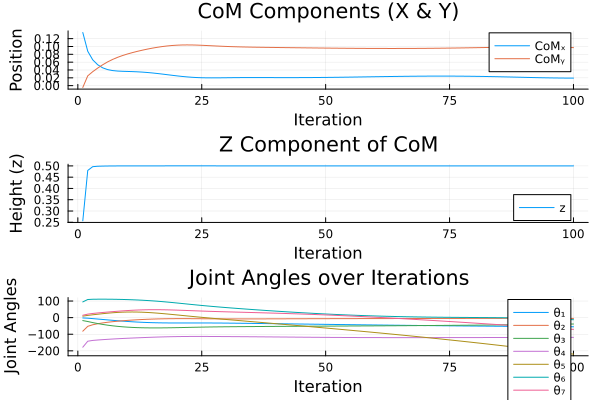

0

In [6]:
# Robot initialization
global rob=CreateRobotKukaLwr();
global θinit=[0.143019, -0.109465, -0.011994, -1.1788, -0.154233, 0.93555, 0.264868];
global CoM0=[-0.0844, -0.01223, 0.6370];
θ_min = [-170, -120, -170, -120, -170, -120, -170] .* π/180
θ_max = [170, 120, 170, 120, 170, 120, 170] .* π/180


# Setting Goals
CoM_target = [0, 0.1 , CoM0[3]]
pinit = MGD(θinit,rob)
global pinit = pinit[1:3,4]
Z_target=[pinit[1], pinit[2], 0.5];


# Connect to Coppelia
global clientID=startsimulation(simx_opmode_oneshot) # On lance une instance de connexion avec VREP
if clientID==0 println("Connected")
    init_pos()
    else println("Connection error")
end

# Calling the Multi task with joint limit avoidance
multi_task_and_joint_limit_avoidance(θinit, Z_target, CoM_target, θ_min, θ_max; α=-0.5, tol_1=1e-2, tol_2=1e-2, do_plot=1)
stopsimulation(clientID,simx_opmode_oneshot)